# Sentiment Prediction using RNN and variants

In this project, we explore Recurrent Neural Networks and its variants to predict sentiments for a list of movie reviews. We implement vanilla RNN, LSTM and GRU and find a good model by trying out different hyperparameters, optimizer, loss function, number of epochs.

## Dataset

Dataset used here is the **Sentence Polarity Dataset v1.0** from Cornell's [Sentiment polarity dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/) 
It containg two files, one each for positive and negative reviews.
We split the dataset into 3 sets - train (60%), validation (20%), test (20%). Each split contains equal number of positive and negative reviews to avoid imbalance.

## Word Embeddings

We used pre-trained [GloVe](https://nlp.stanford.edu/projects/glove/) representations as word embeddings with 300 dimensions.

## Framework and Libraries

We use PyTorch as our framework for building our neural networks.
Libraries needed to run the project are -
* Pandas
* Numpy
* Sklearn
* NLTK
* PyTorch
* TorchText
* SpaCy
* Matplotlib


## Import

In [1]:
conda env list

# conda environments:
#
myTorchEnv               /Users/gammu/.conda/envs/myTorchEnv
newProject               /Users/gammu/.conda/envs/newProject
base                  *  /Users/gammu/opt/anaconda3


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import string
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torchtext
from torchtext import data
import spacy
import time
import matplotlib.pyplot as plt

## Preprocess and prepare dataset for torchtext

In [3]:
def preprocess(text):
    tokens = text.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    # tokens = [token for token in tokens if token not in stop_words]
    tokens = [token.lower() for token in tokens if len(token) > 1]
    return tokens

In [4]:
def getData(path):
    lines = []
    with open(path,'r',errors='ignore') as file:
        lines = file.readlines()
#         for i in range(len(lines)):
#             lines[i] = preprocess(lines[i])
#     print(lines[0:2])
    return np.split(lines, [int(0.6 * len(lines)), int(0.8 * len(lines))])

In [5]:
# if __name__ == "__main__":
dataRootPATH = "/Users/gammu/Documents/study/dlnlp/Assignment_1/rt-polaritydata/rt-polaritydata"
posReviewPATH = os.path.join(dataRootPATH, "rt-polarity.pos")
negReviewPATH = os.path.join(dataRootPATH, "rt-polarity.neg")
train_p, val_p, test_p = getData(posReviewPATH)
train_n, val_n, test_n = getData(negReviewPATH)
train_X = []
train_X.extend(train_p)
train_X.extend(train_n)
train_Y = [1] * len(train_p) + [0] * len(train_n)
val_X = []
val_X.extend(val_p)
val_X.extend(val_n)
val_Y = [1] * len(val_p) + [0] * len(val_n)
test_X = []
test_X.extend(test_p)
test_X.extend(test_n)
test_Y = [1] * len(test_p) + [0] * len(test_n)
train_X, train_Y = shuffle(np.array(train_X),np.array(train_Y),random_state = 0)
val_X, val_Y = shuffle(np.array(val_X), np.array(val_Y), random_state = 0)
test_X, test_Y = shuffle(np.array(test_X), np.array(test_Y), random_state = 0)
# print(len(train_p),len(val_p),len(test_p),len(train_p)+len(val_p)+len(test_p))
# print(train_p[0])
# print(train_n[0])
# print(train_X[3198])
print(len(train_Y))

6396


In [6]:
train = pd.DataFrame({'Text':train_X,'Label':train_Y})
val = pd.DataFrame({'Text':val_X,'Label':val_Y})
test = pd.DataFrame({'Text':test_X,'Label':test_Y})

In [7]:
print(len(train),len(val),len(test))

6396 2132 2134


In [8]:
!mkdir review_data

mkdir: review_data: File exists


In [9]:
train.to_csv("review_data/train.csv", index=False)
test.to_csv("review_data/test.csv", index=False)
val.to_csv("review_data/valid.csv", index=False)

In [10]:
len(train)

6396

In [11]:
del train_p,val_p,test_p,train_n,val_n,test_n

In [12]:
is_cuda = torch.cuda.is_available()
is_cuda

False

## Load data in torchtext

In [13]:
spacy_en = spacy.load('en')

In [14]:
TEXT = data.Field(tokenize="spacy",include_lengths = True)
LABEL = data.LabelField(dtype=torch.float)

/Users/gammu/.conda/envs/myTorchEnv/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/gammu/.conda/envs/myTorchEnv/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [15]:
train_data, valid_data, test_data = data.TabularDataset.splits(
    path="review_data/", train="train.csv", 
    validation="valid.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

/Users/gammu/.conda/envs/myTorchEnv/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/Users/gammu/.conda/envs/myTorchEnv/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


## Build vocabulary using training data text. Use Glove to get word vectors

In [16]:
TEXT.build_vocab(train_data, 
                 vectors=torchtext.vocab.Vectors("glove.6B/glove.6B.300d.txt"), 
                 max_size=20000, 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

100%|█████████▉| 399999/400000 [00:32<00:00, 12426.02it/s]


In [17]:
len(TEXT.vocab)

14470

In [18]:
len(LABEL.vocab)

2

## Get Batch iterators for training, validation and test sets

In [19]:
BATCH_SIZE = 20

device = torch.device('cuda' if is_cuda else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=BATCH_SIZE, 
    sort_within_batch = True,
    device=device)

/Users/gammu/.conda/envs/myTorchEnv/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [20]:
LABEL.vocab.freqs

Counter({'1': 3198, '0': 3198})

In [21]:
vars(train_data.examples[0])

{'Text': ['davis',
  '.',
  '.',
  '.',
  'gets',
  'vivid',
  'performances',
  'from',
  'her',
  'cast',
  'and',
  'pulls',
  'off',
  'some',
  'deft',
  'ally',
  'mcbeal',
  '-',
  'style',
  'fantasy',
  'sequences',
  '.'],
 'Label': '1'}

In [22]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '.', 'the', ',', 'a', 'and', 'of', 'to', '-']

## Define RNN, LSTM and GRU models using torch.nn

In [23]:
class RNN_model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim,padding_idx = pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        embed = self.embedding(text)
#         packed_embed = nn.utils.rnn.pack_padded_sequence(embed, text_lengths)#,enforce_sorted=False)
#         packed_output, hidden = self.rnn(packed_embed)
#         output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output, hidden = self.rnn(embed)
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))

In [24]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        embed = self.dropout(self.embedding(text))
        packed_embed = nn.utils.rnn.pack_padded_sequence(embed, text_lengths,enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embed)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

In [25]:
class GRU_model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim,padding_idx = pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        embed = self.embedding(text)
#         packed_embed = nn.utils.rnn.pack_padded_sequence(embed, text_lengths)#,enforce_sorted=False)
#         packed_output, hidden = self.rnn(packed_embed)
#         output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output, hidden = self.gru(embed)
        hidden = self.dropout(hidden[-1::])
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))

## Utility functions

In [26]:
def accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.Text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.Label)
        acc = accuracy(predictions, batch.Label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    target_labels = torch.tensor([], dtype=torch.long, device=device)
    all_predictions = torch.tensor([], device=device)
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.Text
            labels = batch.Label
            predictions = model(text, text_lengths).squeeze(1)
            target_labels = torch.cat((target_labels, labels), 0)
            all_predictions = torch.cat((all_predictions, torch.round(torch.sigmoid(predictions))), 0)
            loss = criterion(predictions, labels)
            acc = accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        assert target_labels.ndim == 1
        assert all_predictions.ndim == 1
        tp = (target_labels * all_predictions).sum().to(torch.float32)
        tn = ((1 - target_labels) * (1 - all_predictions)).sum().to(torch.float32)
        fp = ((1 - target_labels) * all_predictions).sum().to(torch.float32)
        fn = (target_labels * (1 - all_predictions)).sum().to(torch.float32)
#         print(tp,tn,fp,fn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = f1_score(target_labels, all_predictions, average=None)
    return epoch_loss / len(iterator), epoch_acc / len(iterator), precision, recall, f1

In [29]:
def train_eval_model(N_EPOCHS,model,optimizer, criterion,train_iterator,valid_iterator,model_type):
    best_valid_loss = float('inf')
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for epoch in range(N_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, p,r,f = evaluate(model, valid_iterator, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), (model_type+".pt"))
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        print(f'Epoch: {epoch+1} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')
    return train_loss_list,valid_loss_list,train_acc_list,valid_acc_list

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time // 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [31]:
def plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x = range(N_EPOCHS)
    plt.plot(x,train_loss_list,'b',label='Train Loss')
    plt.plot(x,valid_loss_list,'g',label='Valid Loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x,train_acc_list,'b',label='Train Accuracy')
    plt.plot(x,valid_acc_list,'g',label='Valid accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Initialize, train and experiment with RNN model

In [32]:
## Initialize vanilla RNN model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

rnn_model = RNN_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, PAD_IDX)
rnn_model = rnn_model.to(device)
rnn_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(rnn_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [33]:
# Train and evaluate RNN model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 rnn_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "RNN_model")

/Users/gammu/.conda/envs/myTorchEnv/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1 | Epoch Time: 0m 4s
	Train Loss: 0.692 | Train Acc: 51.32%
	Valid Loss: 0.694 | Valid Acc: 51.45%
Epoch: 2 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 52.15%
	Valid Loss: 0.693 | Valid Acc: 51.88%
Epoch: 3 | Epoch Time: 0m 4s
	Train Loss: 0.690 | Train Acc: 54.00%
	Valid Loss: 0.692 | Valid Acc: 51.48%
Epoch: 4 | Epoch Time: 0m 4s
	Train Loss: 0.689 | Train Acc: 55.02%
	Valid Loss: 0.692 | Valid Acc: 52.07%
Epoch: 5 | Epoch Time: 0m 4s
	Train Loss: 0.688 | Train Acc: 54.88%
	Valid Loss: 0.691 | Valid Acc: 52.88%
Epoch: 6 | Epoch Time: 0m 4s
	Train Loss: 0.687 | Train Acc: 55.85%
	Valid Loss: 0.690 | Valid Acc: 53.60%
Epoch: 7 | Epoch Time: 0m 4s
	Train Loss: 0.686 | Train Acc: 56.54%
	Valid Loss: 0.690 | Valid Acc: 54.11%
Epoch: 8 | Epoch Time: 0m 4s
	Train Loss: 0.684 | Train Acc: 57.91%
	Valid Loss: 0.689 | Valid Acc: 54.27%
Epoch: 9 | Epoch Time: 0m 4s
	Train Loss: 0.683 | Train Acc: 57.64%
	Valid Loss: 0.688 | Valid Acc: 54.50%
Epoch: 10 | Epoch Time: 0m 4s
	Train 

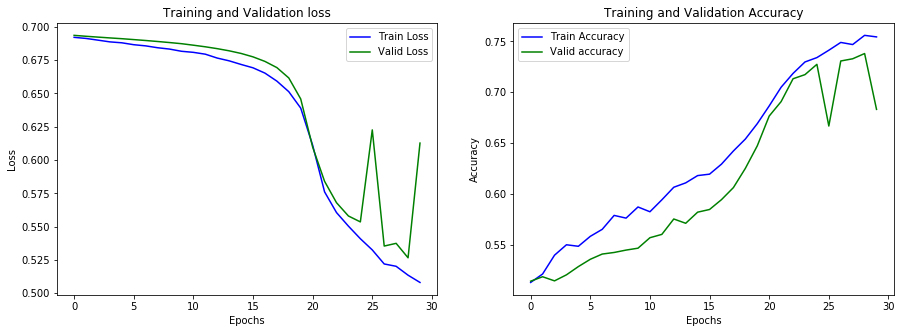

In [34]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 1. Experimenting with number of hidden units in RNN
Doubling hidden units did not improve the model much. The loss and accuracy did not change as smoothly.
Halving the hidden units decreased the accuracy and increased the loss. So, the number of hidden dimensions should be kept unchanged.

In [46]:
## Initialize vanilla RNN model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

rnn_model = RNN_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, PAD_IDX)
rnn_model = rnn_model.to(device)
rnn_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(rnn_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [47]:
# Train and evaluate RNN model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 rnn_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "RNN_model")

Epoch: 1 | Epoch Time: 0m 3s
	Train Loss: 0.694 | Train Acc: 49.91%
	Valid Loss: 0.693 | Valid Acc: 50.87%
Epoch: 2 | Epoch Time: 0m 3s
	Train Loss: 0.692 | Train Acc: 52.20%
	Valid Loss: 0.693 | Valid Acc: 52.12%
Epoch: 3 | Epoch Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 53.27%
	Valid Loss: 0.692 | Valid Acc: 51.74%
Epoch: 4 | Epoch Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 54.37%
	Valid Loss: 0.692 | Valid Acc: 51.79%
Epoch: 5 | Epoch Time: 0m 3s
	Train Loss: 0.689 | Train Acc: 54.50%
	Valid Loss: 0.691 | Valid Acc: 52.54%
Epoch: 6 | Epoch Time: 0m 3s
	Train Loss: 0.689 | Train Acc: 55.46%
	Valid Loss: 0.691 | Valid Acc: 52.26%
Epoch: 7 | Epoch Time: 0m 3s
	Train Loss: 0.688 | Train Acc: 55.77%
	Valid Loss: 0.690 | Valid Acc: 52.87%
Epoch: 8 | Epoch Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 56.52%
	Valid Loss: 0.690 | Valid Acc: 54.11%
Epoch: 9 | Epoch Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 57.80%
	Valid Loss: 0.689 | Valid Acc: 54.13%
Epoch: 10 | Epoch Time: 0m 3s
	Train 

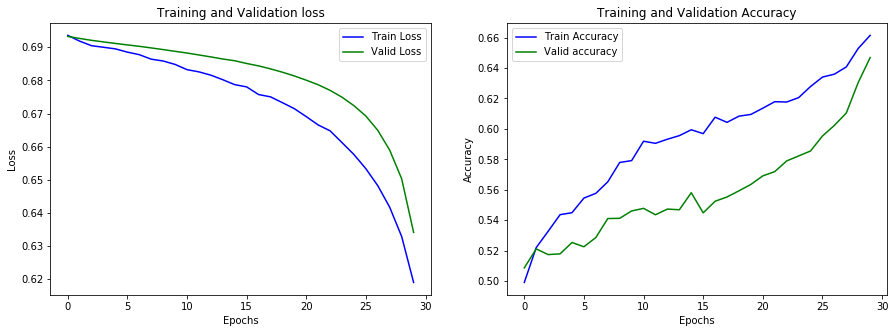

In [48]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 2. Experimenting with dropout for RNN
Changing the dropout percent to 0.8 significantly reduced the performance of the model. Even though changing it to 0.2 kept the final accuracy unchanged, the graph of accuracy over the epochs is not as smooth as that with 0.5. So, dropout percent should be kept at 0.5

In [51]:
## Initialize vanilla RNN model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

rnn_model = RNN_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, PAD_IDX)
rnn_model = rnn_model.to(device)
rnn_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(rnn_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [52]:
# Train and evaluate RNN model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 rnn_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "RNN_model")

Epoch: 1 | Epoch Time: 0m 4s
	Train Loss: 0.694 | Train Acc: 49.02%
	Valid Loss: 0.694 | Valid Acc: 50.83%
Epoch: 2 | Epoch Time: 0m 4s
	Train Loss: 0.694 | Train Acc: 49.89%
	Valid Loss: 0.693 | Valid Acc: 50.62%
Epoch: 3 | Epoch Time: 0m 4s
	Train Loss: 0.693 | Train Acc: 51.13%
	Valid Loss: 0.693 | Valid Acc: 51.14%
Epoch: 4 | Epoch Time: 0m 4s
	Train Loss: 0.692 | Train Acc: 51.77%
	Valid Loss: 0.692 | Valid Acc: 51.88%
Epoch: 5 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 52.99%
	Valid Loss: 0.692 | Valid Acc: 52.02%
Epoch: 6 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 54.20%
	Valid Loss: 0.692 | Valid Acc: 52.17%
Epoch: 7 | Epoch Time: 0m 5s
	Train Loss: 0.690 | Train Acc: 55.80%
	Valid Loss: 0.691 | Valid Acc: 52.77%
Epoch: 8 | Epoch Time: 0m 5s
	Train Loss: 0.689 | Train Acc: 56.61%
	Valid Loss: 0.691 | Valid Acc: 53.01%
Epoch: 9 | Epoch Time: 0m 4s
	Train Loss: 0.688 | Train Acc: 57.08%
	Valid Loss: 0.690 | Valid Acc: 53.01%
Epoch: 10 | Epoch Time: 0m 4s
	Train 

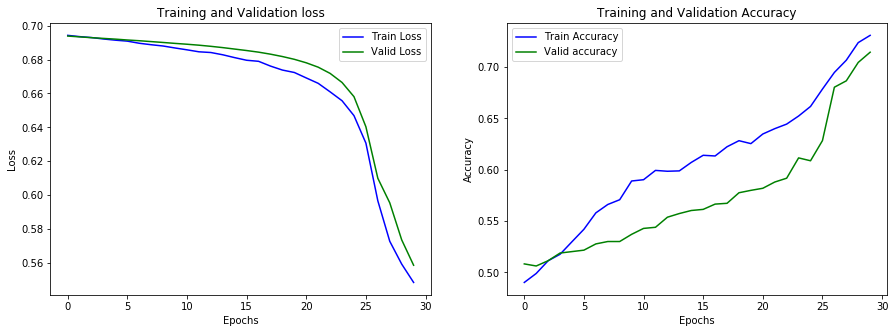

In [53]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 3. Using pre-trained word embeddings without fine tuning for RNN 
Original model calculates gradient wrt weights of the Embedding layer, hence fine-tuning the word vectors. In this experiment, we try to not fine tune the vectors and use only the pre-trained vectors.
We notice that fine-tuning the pre-trained vectors actually made the model unstable. We saw significant stability and gradual increase in accuracy, gradual decrease in loss when we kept the vectors unchanged.

In [54]:
## Initialize vanilla RNN model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

rnn_model = RNN_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, PAD_IDX)
rnn_model = rnn_model.to(device)
rnn_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
rnn_model.embedding.weight.requires_grad=False
rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(rnn_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [55]:
# Train and evaluate RNN model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 rnn_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "RNN_model")

Epoch: 1 | Epoch Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 51.78%
	Valid Loss: 0.691 | Valid Acc: 53.41%
Epoch: 2 | Epoch Time: 0m 2s
	Train Loss: 0.692 | Train Acc: 52.30%
	Valid Loss: 0.691 | Valid Acc: 52.34%
Epoch: 3 | Epoch Time: 0m 1s
	Train Loss: 0.690 | Train Acc: 53.80%
	Valid Loss: 0.690 | Valid Acc: 53.22%
Epoch: 4 | Epoch Time: 0m 1s
	Train Loss: 0.689 | Train Acc: 55.20%
	Valid Loss: 0.689 | Valid Acc: 54.92%
Epoch: 5 | Epoch Time: 0m 1s
	Train Loss: 0.688 | Train Acc: 55.43%
	Valid Loss: 0.689 | Valid Acc: 55.26%
Epoch: 6 | Epoch Time: 0m 2s
	Train Loss: 0.687 | Train Acc: 56.84%
	Valid Loss: 0.688 | Valid Acc: 55.95%
Epoch: 7 | Epoch Time: 0m 2s
	Train Loss: 0.686 | Train Acc: 57.23%
	Valid Loss: 0.687 | Valid Acc: 57.40%
Epoch: 8 | Epoch Time: 0m 1s
	Train Loss: 0.684 | Train Acc: 58.31%
	Valid Loss: 0.686 | Valid Acc: 57.96%
Epoch: 9 | Epoch Time: 0m 1s
	Train Loss: 0.684 | Train Acc: 58.76%
	Valid Loss: 0.685 | Valid Acc: 57.73%
Epoch: 10 | Epoch Time: 0m 1s
	Train 

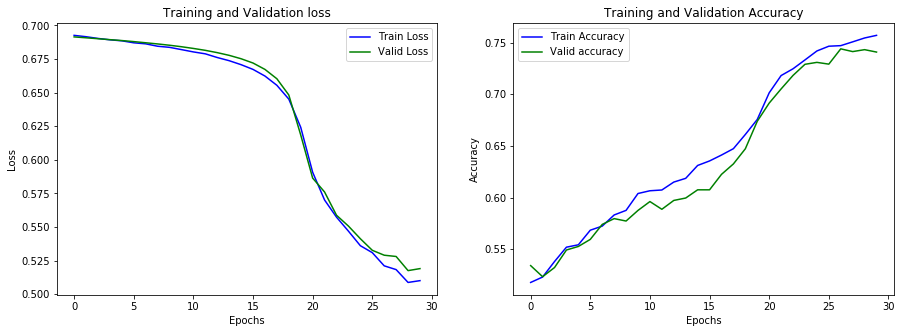

In [56]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

## Initialize, train and experiment with LSTM model

In [34]:
## Initialize LSTM model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

lstm_model = LSTM_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
lstm_model = lstm_model.to(device)
lstm_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
lstm_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.Adam(lstm_model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [35]:
# Train and evaluate LSTM model

N_EPOCHS = 5
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 lstm_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "LSTM_model")


Epoch: 1 | Epoch Time: 0m 30s
	Train Loss: 0.576 | Train Acc: 69.89%
	Valid Loss: 0.596 | Valid Acc: 74.86%
Epoch: 2 | Epoch Time: 0m 30s
	Train Loss: 0.422 | Train Acc: 80.81%
	Valid Loss: 0.455 | Valid Acc: 78.86%
Epoch: 3 | Epoch Time: 0m 33s
	Train Loss: 0.292 | Train Acc: 88.20%
	Valid Loss: 0.527 | Valid Acc: 77.91%
Epoch: 4 | Epoch Time: 0m 37s
	Train Loss: 0.207 | Train Acc: 92.07%
	Valid Loss: 0.494 | Valid Acc: 78.77%
Epoch: 5 | Epoch Time: 0m 37s
	Train Loss: 0.130 | Train Acc: 95.05%
	Valid Loss: 0.534 | Valid Acc: 77.96%


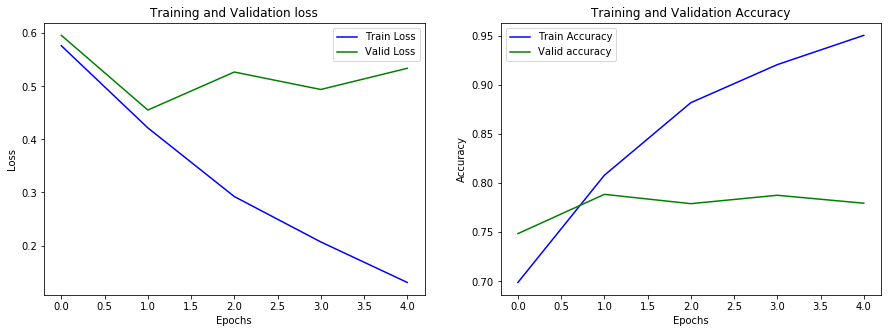

In [36]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 1. Experimenting with number of hidden units in LSTM
Doubling hidden units did not improve the model much. Halving the hidden units increased the loss. So, the number of hidden dimensions should be kept unchanged.

In [66]:
## Initialize LSTM model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

lstm_model = LSTM_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
lstm_model = lstm_model.to(device)
lstm_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
lstm_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.Adam(lstm_model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [67]:
# Train and evaluate LSTM model

N_EPOCHS = 5
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 lstm_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "LSTM_model")


Epoch: 1 | Epoch Time: 0m 23s
	Train Loss: 0.588 | Train Acc: 66.97%
	Valid Loss: 0.472 | Valid Acc: 77.23%
Epoch: 2 | Epoch Time: 0m 22s
	Train Loss: 0.417 | Train Acc: 80.95%
	Valid Loss: 0.454 | Valid Acc: 78.71%
Epoch: 3 | Epoch Time: 0m 26s
	Train Loss: 0.307 | Train Acc: 87.11%
	Valid Loss: 0.562 | Valid Acc: 76.18%
Epoch: 4 | Epoch Time: 0m 32s
	Train Loss: 0.210 | Train Acc: 91.52%
	Valid Loss: 0.529 | Valid Acc: 78.07%
Epoch: 5 | Epoch Time: 0m 30s
	Train Loss: 0.138 | Train Acc: 94.90%
	Valid Loss: 0.677 | Valid Acc: 78.13%


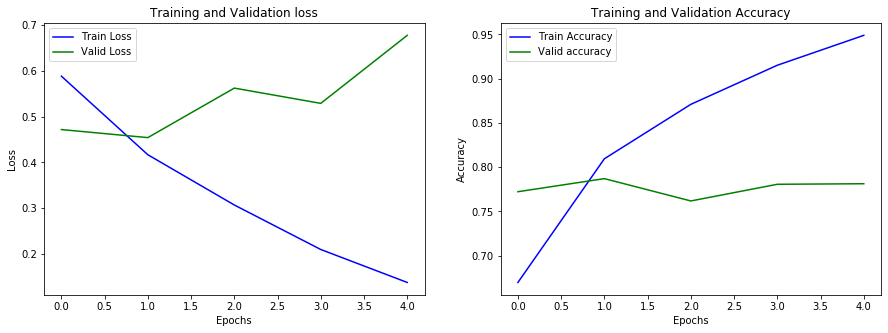

In [68]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 2. Experimenting with number of layers for LSTM
Changing the number of layers to 1 increased the loss and did not improve the accuracy.
Increasing the number of layers increased accuracy and made the model more stable.

In [72]:
## Initialize LSTM model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

lstm_model = LSTM_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
lstm_model = lstm_model.to(device)
lstm_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
lstm_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.Adam(lstm_model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [73]:
# Train and evaluate LSTM model

N_EPOCHS = 5
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 lstm_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "LSTM_model")


Epoch: 1 | Epoch Time: 0m 39s
	Train Loss: 0.586 | Train Acc: 67.84%
	Valid Loss: 0.481 | Valid Acc: 76.64%
Epoch: 2 | Epoch Time: 0m 39s
	Train Loss: 0.422 | Train Acc: 80.32%
	Valid Loss: 0.444 | Valid Acc: 78.32%
Epoch: 3 | Epoch Time: 0m 47s
	Train Loss: 0.304 | Train Acc: 87.15%
	Valid Loss: 0.459 | Valid Acc: 79.24%
Epoch: 4 | Epoch Time: 0m 50s
	Train Loss: 0.205 | Train Acc: 92.00%
	Valid Loss: 0.534 | Valid Acc: 78.61%
Epoch: 5 | Epoch Time: 0m 52s
	Train Loss: 0.138 | Train Acc: 94.95%
	Valid Loss: 0.585 | Valid Acc: 79.33%


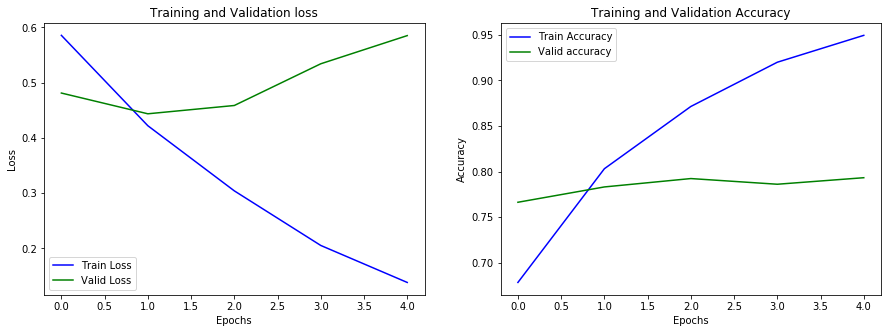

In [74]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 3. Using pre-trained word embeddings without fine tuning for LSTM 
Original model calculates gradient wrt weights of the Embedding layer, hence fine-tuning the word vectors. In this experiment, we try to not fine tune the vectors and use only the pre-trained vectors.
We saw significant improvement when we kept the vectors unchanged.

In [81]:
## Initialize LSTM model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 4
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

lstm_model = LSTM_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
lstm_model = lstm_model.to(device)
lstm_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
lstm_model.embedding.weight.requires_grad=False
lstm_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.Adam(lstm_model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [82]:
# Train and evaluate LSTM model

N_EPOCHS = 5
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 lstm_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "LSTM_model")


Epoch: 1 | Epoch Time: 0m 39s
	Train Loss: 0.592 | Train Acc: 68.32%
	Valid Loss: 0.503 | Valid Acc: 73.97%
Epoch: 2 | Epoch Time: 0m 40s
	Train Loss: 0.526 | Train Acc: 73.63%
	Valid Loss: 0.507 | Valid Acc: 74.94%
Epoch: 3 | Epoch Time: 0m 39s
	Train Loss: 0.502 | Train Acc: 76.17%
	Valid Loss: 0.484 | Valid Acc: 76.03%
Epoch: 4 | Epoch Time: 0m 36s
	Train Loss: 0.479 | Train Acc: 76.72%
	Valid Loss: 0.472 | Valid Acc: 76.04%
Epoch: 5 | Epoch Time: 0m 38s
	Train Loss: 0.463 | Train Acc: 78.16%
	Valid Loss: 0.464 | Valid Acc: 75.90%


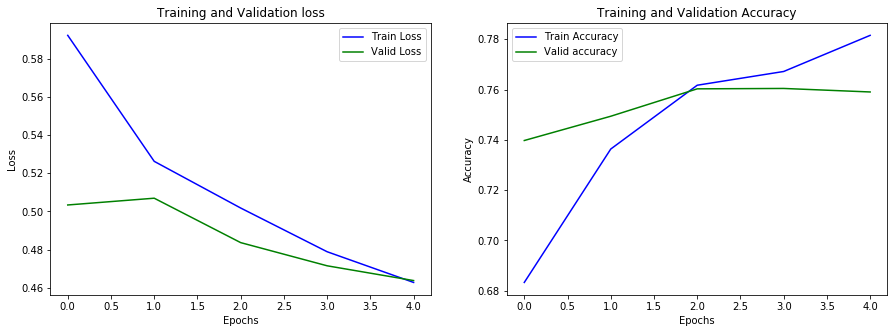

In [83]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

## Initialize, train and experiment with GRU model

In [99]:
## Initialize GRU model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

gru_model = GRU_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX)
gru_model = gru_model.to(device)
gru_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
gru_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
gru_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(gru_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [100]:
# Train and evaluate GRU model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 gru_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "GRU_model")

Epoch: 1 | Epoch Time: 0m 16s
	Train Loss: 0.695 | Train Acc: 49.54%
	Valid Loss: 0.694 | Valid Acc: 49.94%
Epoch: 2 | Epoch Time: 0m 18s
	Train Loss: 0.693 | Train Acc: 50.98%
	Valid Loss: 0.693 | Valid Acc: 50.12%
Epoch: 3 | Epoch Time: 0m 16s
	Train Loss: 0.692 | Train Acc: 51.92%
	Valid Loss: 0.692 | Valid Acc: 50.69%
Epoch: 4 | Epoch Time: 0m 14s
	Train Loss: 0.693 | Train Acc: 51.41%
	Valid Loss: 0.692 | Valid Acc: 52.27%
Epoch: 5 | Epoch Time: 0m 14s
	Train Loss: 0.692 | Train Acc: 52.14%
	Valid Loss: 0.692 | Valid Acc: 54.14%
Epoch: 6 | Epoch Time: 0m 14s
	Train Loss: 0.692 | Train Acc: 52.01%
	Valid Loss: 0.691 | Valid Acc: 54.81%
Epoch: 7 | Epoch Time: 0m 14s
	Train Loss: 0.692 | Train Acc: 52.47%
	Valid Loss: 0.691 | Valid Acc: 55.03%
Epoch: 8 | Epoch Time: 0m 14s
	Train Loss: 0.691 | Train Acc: 52.83%
	Valid Loss: 0.691 | Valid Acc: 56.88%
Epoch: 9 | Epoch Time: 0m 15s
	Train Loss: 0.691 | Train Acc: 52.91%
	Valid Loss: 0.691 | Valid Acc: 56.93%
Epoch: 10 | Epoch Time: 0m 1

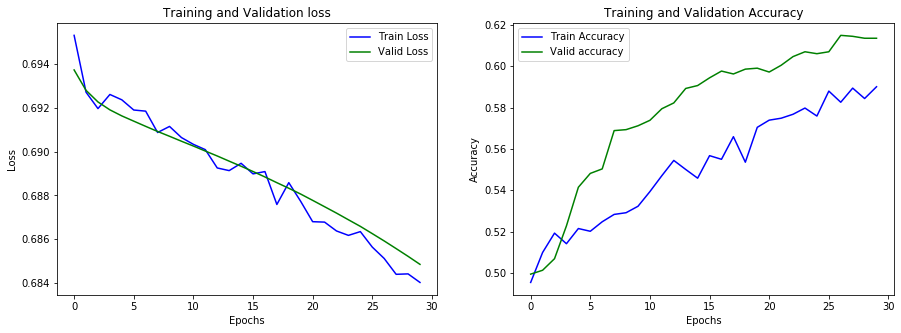

In [101]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 1. Experimenting with number of hidden units in GRU
Doubling hidden units did not improve the model. The loss and accuracy did not change as smoothly.
Halving the hidden units decreased the accuracy and increased the loss. So, the number of hidden dimensions should be kept unchanged.

In [93]:
## Initialize GRU model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

gru_model = GRU_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX)
gru_model = gru_model.to(device)
gru_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
gru_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
gru_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(gru_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [94]:
# Train and evaluate GRU model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 gru_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "GRU_model")

Epoch: 1 | Epoch Time: 0m 38s
	Train Loss: 0.694 | Train Acc: 48.29%
	Valid Loss: 0.694 | Valid Acc: 48.91%
Epoch: 2 | Epoch Time: 0m 39s
	Train Loss: 0.694 | Train Acc: 50.61%
	Valid Loss: 0.693 | Valid Acc: 49.97%
Epoch: 3 | Epoch Time: 0m 35s
	Train Loss: 0.693 | Train Acc: 51.15%
	Valid Loss: 0.693 | Valid Acc: 51.70%
Epoch: 4 | Epoch Time: 0m 35s
	Train Loss: 0.692 | Train Acc: 51.75%
	Valid Loss: 0.693 | Valid Acc: 52.20%
Epoch: 5 | Epoch Time: 0m 34s
	Train Loss: 0.692 | Train Acc: 51.64%
	Valid Loss: 0.692 | Valid Acc: 53.46%
Epoch: 6 | Epoch Time: 0m 34s
	Train Loss: 0.692 | Train Acc: 52.51%
	Valid Loss: 0.692 | Valid Acc: 54.58%
Epoch: 7 | Epoch Time: 0m 33s
	Train Loss: 0.692 | Train Acc: 52.57%
	Valid Loss: 0.692 | Valid Acc: 55.28%
Epoch: 8 | Epoch Time: 0m 33s
	Train Loss: 0.692 | Train Acc: 52.76%
	Valid Loss: 0.692 | Valid Acc: 56.36%
Epoch: 9 | Epoch Time: 0m 33s
	Train Loss: 0.691 | Train Acc: 53.71%
	Valid Loss: 0.691 | Valid Acc: 56.96%
Epoch: 10 | Epoch Time: 0m 3

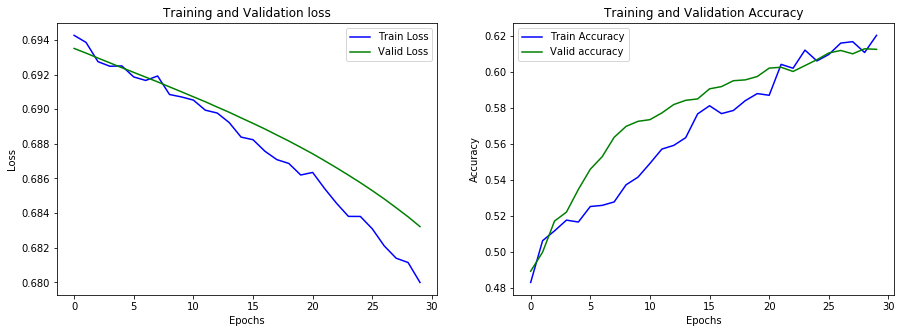

In [95]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 2. Experimenting with number of layers for GRU
Changing the number of layers to 1 decreased the accuracy. Increasing the number of layers also did not have a positive effect on the model. So keeping the number of layers unchanged.

In [90]:
## Initialize GRU model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 3
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

gru_model = GRU_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX)
gru_model = gru_model.to(device)
gru_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
gru_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
gru_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(gru_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [91]:
# Train and evaluate GRU model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 gru_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "GRU_model")

Epoch: 1 | Epoch Time: 0m 24s
	Train Loss: 0.693 | Train Acc: 51.49%
	Valid Loss: 0.693 | Valid Acc: 50.79%
Epoch: 2 | Epoch Time: 0m 25s
	Train Loss: 0.693 | Train Acc: 51.94%
	Valid Loss: 0.693 | Valid Acc: 51.53%
Epoch: 3 | Epoch Time: 0m 21s
	Train Loss: 0.693 | Train Acc: 50.51%
	Valid Loss: 0.693 | Valid Acc: 52.18%
Epoch: 4 | Epoch Time: 0m 25s
	Train Loss: 0.692 | Train Acc: 51.20%
	Valid Loss: 0.693 | Valid Acc: 53.24%
Epoch: 5 | Epoch Time: 0m 24s
	Train Loss: 0.693 | Train Acc: 51.67%
	Valid Loss: 0.692 | Valid Acc: 54.45%
Epoch: 6 | Epoch Time: 0m 24s
	Train Loss: 0.692 | Train Acc: 52.40%
	Valid Loss: 0.692 | Valid Acc: 54.74%
Epoch: 7 | Epoch Time: 0m 23s
	Train Loss: 0.692 | Train Acc: 52.41%
	Valid Loss: 0.692 | Valid Acc: 55.14%
Epoch: 8 | Epoch Time: 0m 20s
	Train Loss: 0.692 | Train Acc: 51.68%
	Valid Loss: 0.692 | Valid Acc: 55.69%
Epoch: 9 | Epoch Time: 0m 20s
	Train Loss: 0.692 | Train Acc: 53.24%
	Valid Loss: 0.692 | Valid Acc: 56.57%
Epoch: 10 | Epoch Time: 0m 2

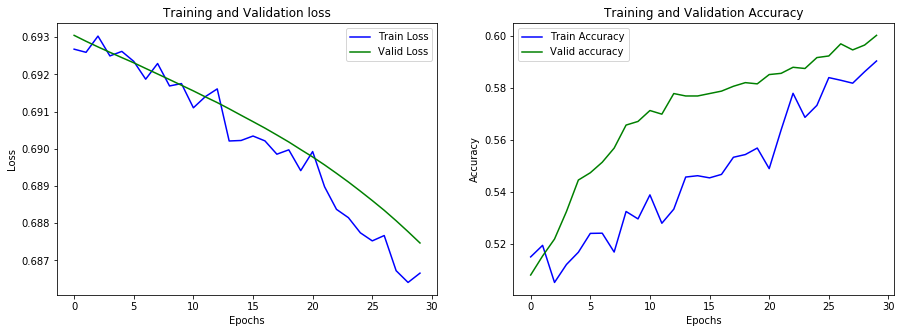

In [92]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

### 3. Using pre-trained word embeddings without fine tuning for GRU 
Original model calculates gradient wrt weights of the Embedding layer, hence fine-tuning the word vectors. In this experiment, we try to not fine tune the vectors and use only the pre-trained vectors.
We did not see any significant improvement when we kept the vectors unchanged.

In [87]:
## Initialize GRU model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

gru_model = GRU_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX)
gru_model = gru_model.to(device)
gru_model.embedding.weight.data.copy_(TEXT.vocab.vectors)
gru_model.embedding.weight.requires_grad=False
gru_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
gru_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(gru_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [88]:
# Train and evaluate GRU model

N_EPOCHS = 30
train_loss_list,valid_loss_list,train_acc_list,valid_acc_list = train_eval_model(N_EPOCHS,
                                                                                 gru_model,
                                                                                 optimizer, 
                                                                                 criterion,
                                                                                 train_iterator,
                                                                                 valid_iterator,
                                                                                 "GRU_model")

Epoch: 1 | Epoch Time: 0m 11s
	Train Loss: 0.694 | Train Acc: 50.33%
	Valid Loss: 0.693 | Valid Acc: 51.11%
Epoch: 2 | Epoch Time: 0m 13s
	Train Loss: 0.693 | Train Acc: 50.25%
	Valid Loss: 0.693 | Valid Acc: 52.27%
Epoch: 3 | Epoch Time: 0m 11s
	Train Loss: 0.693 | Train Acc: 51.38%
	Valid Loss: 0.693 | Valid Acc: 52.68%
Epoch: 4 | Epoch Time: 0m 10s
	Train Loss: 0.692 | Train Acc: 51.63%
	Valid Loss: 0.692 | Valid Acc: 52.83%
Epoch: 5 | Epoch Time: 0m 10s
	Train Loss: 0.692 | Train Acc: 51.47%
	Valid Loss: 0.692 | Valid Acc: 53.40%
Epoch: 6 | Epoch Time: 0m 10s
	Train Loss: 0.692 | Train Acc: 51.85%
	Valid Loss: 0.692 | Valid Acc: 53.72%
Epoch: 7 | Epoch Time: 0m 10s
	Train Loss: 0.692 | Train Acc: 51.85%
	Valid Loss: 0.692 | Valid Acc: 53.72%
Epoch: 8 | Epoch Time: 0m 10s
	Train Loss: 0.691 | Train Acc: 53.22%
	Valid Loss: 0.691 | Valid Acc: 54.94%
Epoch: 9 | Epoch Time: 0m 12s
	Train Loss: 0.691 | Train Acc: 53.50%
	Valid Loss: 0.691 | Valid Acc: 55.31%
Epoch: 10 | Epoch Time: 0m 1

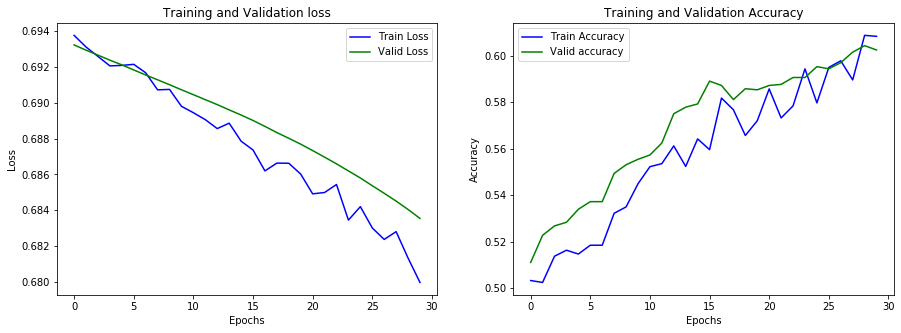

In [89]:
# Plot loss and accuracy vs number of iterations for training and validation sets
plot_loss_acc(N_EPOCHS,train_loss_list,valid_loss_list,train_acc_list,valid_acc_list)

## Evaluating models on test set

The saved models are tested with the test set. Their precision, recall, f1 score are as calculated below. We observe some difference between the values for the models. LSTM has the highest values for accuracy, precision, recall and f1 score. This is probably because we have used the bi-LSTM model which better captures the relationships between different parts of the review. 

In [102]:
# Test trained RNN model
criterion = nn.BCEWithLogitsLoss()
rnn_model.load_state_dict(torch.load('RNN_model.pt'))
test_loss, test_acc, p, r, f1 = evaluate(rnn_model, test_iterator, criterion)
print(f'RNN Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {p:.4f} | Recall: {r:.4f} | F1 Score: {f1}')

RNN Test Loss: 0.521 | Test Acc: 74.43% | Precision: 0.7441 | Recall: 0.7441 | F1 Score: [0.74414246 0.74414246]


In [103]:
# Test trained LSTM model
criterion = nn.BCEWithLogitsLoss()
lstm_model.load_state_dict(torch.load('LSTM_model.pt'))
test_loss, test_acc, p, r, f1 = evaluate(lstm_model, test_iterator, criterion)
print(f'LSTM Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {p:.4f} | Recall: {r:.4f} | F1 Score: {f1}')

LSTM Test Loss: 0.467 | Test Acc: 77.58% | Precision: 0.8274 | Recall: 0.6963 | F1 Score: [0.79201042 0.7562341 ]


In [104]:
# Test trained GRU model
criterion = nn.BCEWithLogitsLoss()
gru_model.load_state_dict(torch.load('GRU_model.pt'))
test_loss, test_acc, p, r, f1 = evaluate(gru_model, test_iterator, criterion)
print(f'GRU Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {p:.4f} | Recall: {r:.4f} | F1 Score: {f1}')

GRU Test Loss: 0.684 | Test Acc: 62.97% | Precision: 0.6224 | Recall: 0.6626 | F1 Score: [0.61791768 0.64185202]
